**Import Packages**

In [ ]:
import cv2
from PIL import Image
import sys
import os
import urllib
# import tensorflow.contrib.tensorrt as trt
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
import time
from tf_trt_models.detection import download_detection_model, build_detection_graph

%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





In [ ]:
MODEL = 'MobNv1_Grayscale/'
CONFIG_FILE = MODEL + 'Frozen/pipeline.config'
CHECKPOINT_FILE = MODEL + 'Frozen/model.ckpt'    

**Generating the Frozen Inference Graph**

In [ ]:
# Generating The Frozen_Inference_Graph from the trained model (checkpoints)

frozen_graph, input_names, output_names = build_detection_graph(
    config = '/home/mohamed/Dev/Gradp/DL_Models/MobNv1_Grayscale/Frozen/pipeline.config',
    checkpoint = CHECKPOINT_FILE,
    score_threshold = 0.3,
    batch_size = 1
)

INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:Restoring parameters from MobNv1_Grayscale/Frozen/model.ckpt
Instructions for updating:
Use standard file APIs to check for files with this prefix.

INFO:tensorflow:Restoring parameters from MobNv1_Grayscale/Frozen/model.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 199 variables.
INFO:tensorflow:Converted 199 variables to const ops.



Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: .generated_model/saved_model/saved_model.pb


INFO:tensorflow:SavedModel written to: .generated_model/saved_model/saved_model.pb


INFO:tensorflow:Writing pipeline config file to .generated_model/pipeline.config


INFO:tensorflow:Writing pipeline config file to .generated_model/pipeline.config


**Generating the Optimized Model**

In [ ]:
# Generating The Optimized TensorRT Model from the Frozen model

trt_graph = trt.create_inference_graph(
    input_graph_def = frozen_graph,
    outputs = output_names,
    max_batch_size = 1,
    max_workspace_size_bytes = 1 << 25,
    precision_mode = 'FP16',
    minimum_segment_size = 50
)

INFO:tensorflow:Linked TensorRT version: (5, 1, 5)


INFO:tensorflow:Linked TensorRT version: (5, 1, 5)


INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)


INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)


INFO:tensorflow:Running against TensorRT version 5.1.5


INFO:tensorflow:Running against TensorRT version 5.1.5


In [ ]:
# Serializing and Writing the pb model to disk

with open( MODEL + '/ssd_inception_v2_coco_trt.pb', 'wb') as f:
    f.write(trt_graph.SerializeToString())

In [ ]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

**Image Test**

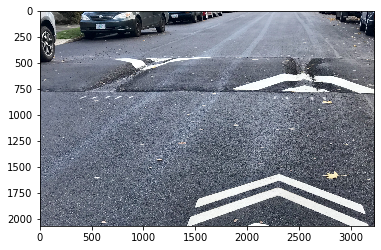

In [ ]:
# Image Test.....................................
IMAGE_PATH = 'bumpy.jpg' 

image = Image.open(IMAGE_PATH)
plt.imshow(image)
image_resized = np.array(image.resize((300, 300)))
image = np.array(image)

In [ ]:
# Testing the model on an sample image

import time
start_time = time.time()

scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], 
                                                      feed_dict={tf_input: image_resized[None, ...]})

boxes = boxes[0] # index by 0 to remove batch dimension
scores = scores[0]
classes = classes[0]
num_detections = num_detections[0]

# # GPIO Signal of JETSON NANO ........................
# if scores[0] > 0.3:
#     GPIO.output(18, GPIO.HIGH) 
#     print('Bump :(')
# else:
#     print('No Bump :)')
#     GPIO.output(18, GPIO.LOW) 
# #....................................

print("--- %s seconds ---" % (time.time() - start_time))

**Output**

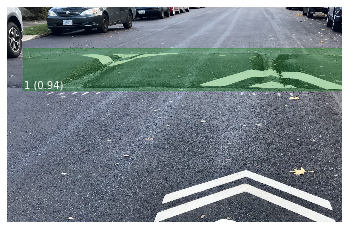

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure()   # name of the figure ( as a whole)
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image)

plt.axis('off')

# plot boxes exceeding score threshold
for i in range(int(num_detections)):  #####
    # scale box to image coordinates
    box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])

    # display rectangle
    patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')

plt.ioff()
plt.show()
#plt.savefig("img9.png", bbox_inches='tight', pad_inches = 0)

plt.close(fig)